## Config

In [16]:
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
from collections import namedtuple
from sklearn.preprocessing import MinMaxScaler
import itertools
from datetime import datetime
import math
import matplotlib.pyplot as plt

Train_val_dataset = namedtuple("Train_val_dataset", ["train", "validate"])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 100
input_size = 5
hidden_size = 256
time_steps = 10 # seq_length
num_layers = 1
num_classes = 1
learning_rate = 0.001
num_epochs = 200
splitting_rate = 0.7
FEATURES = ["Open", "High", "Low", "Close", "Volume"]
SCALER = {k: MinMaxScaler(feature_range=(0,1)) for k in FEATURES}
SAVE_MODEL_PATH = "lstm_ITA.pth"

## Pre-processing Dataset

In [17]:
def prepare_datasets(datasets, time_steps, batch_size, splitting_rate=0.67):
    # (4269, 5) -> Drop first 20 days, Train: 36*100+15, Validate: 6*100+15 (ITA)
    drop_days = datasets.shape[0] % batch_size
    idx = 36*batch_size+(drop_days-time_steps*2)+time_steps
    return Train_val_dataset(train=datasets[(drop_days-time_steps*2):idx],
                             validate=datasets[idx:])
    
def convert_int64_to_datetime(int64_date: int):
    day = math.floor(int64_date % 100)
    month = math.floor((int64_date / 100) % 100)
    year = math.floor(int64_date / 10000)
    return datetime(year=year, month=month, day=day)

def load_df(symbol):
    df = pd.read_csv(r"C:\Users\Admin\Neural Network\LSTM Stock Prediction\CafeF.HSX.Upto03.01.2024.csv")
    df = df[df['<Ticker>'] == symbol]
    df = df.rename({
        '<Ticker>': 'Ticker',
        '<DTYYYYMMDD>': 'Date',
        '<Open>': 'Open',
        '<High>': 'High',
        '<Low>': 'Low',
        '<Close>': 'Close',
        '<Volume>': 'Volume'
    }, axis=1)
    df["Date"] = df["Date"].apply(convert_int64_to_datetime)
    df.index = df["Date"]
    df = df.drop(columns=["Date", "Ticker"])
    df = df.astype('float32')
    df = df.sort_index(ascending=True)
    return df
    
df = load_df("ITA")
print("Before scaling: \n", df)
for col in FEATURES:
    df[col] = SCALER[col].fit_transform(df[col].values.reshape(-1, 1))
    
print("After scaling:\n", df) # (4269, 5) -> Drop first 20 days, Train: 36*100, Validate: 6*100
print(df.describe())
train_val_datasets = prepare_datasets(df, time_steps, batch_size)

Before scaling: 
                Open     High      Low    Close      Volume
Date                                                      
2006-11-15   8.5968   8.5968   8.5968   8.5993     10900.0
2006-11-16   8.9152   8.9948   8.9152   8.9975     13190.0
2006-11-17   9.3928   9.3928   9.3928   9.3956     53180.0
2006-11-20   9.7908   9.7908   9.7908   9.7937    123400.0
2006-11-21  10.2684  10.2684  10.2684  10.2714     84500.0
...             ...      ...      ...      ...         ...
2023-12-27   6.8000   6.8000   6.6700   6.7000   4871400.0
2023-12-28   6.7500   6.7800   6.4000   6.4200  10548700.0
2023-12-29   6.4300   6.5100   6.4100   6.4600   4961100.0
2024-01-02   6.5900   6.6000   6.4100   6.4500   4881300.0
2024-01-03   6.4500   6.7800   6.4000   6.7000   6480000.0

[4269 rows x 5 columns]
After scaling:
                 Open      High       Low     Close    Volume
Date                                                        
2006-11-15  0.225738  0.223679  0.232359  0.226402  

## Training, Validation Datasets

In [18]:
training_datasets, validation_datasets = train_val_datasets.train, train_val_datasets.validate
print(training_datasets.shape, validation_datasets.shape) # (3620, 5) (620, 5)
print(training_datasets, "\n")
print(validation_datasets)

(3610, 5) (610, 5)
                Open      High       Low     Close    Volume
Date                                                        
2007-01-24  0.679788  0.678937  0.657932  0.647161  0.002948
2007-01-25  0.611153  0.610119  0.625610  0.615208  0.004069
2007-01-26  0.616433  0.641881  0.641771  0.647161  0.002523
2007-01-29  0.653390  0.652468  0.657932  0.657814  0.002010
2007-01-30  0.679788  0.684230  0.695641  0.689771  0.003440
...              ...       ...       ...       ...       ...
2021-07-22  0.136303  0.143648  0.140428  0.145822  0.096524
2021-07-23  0.143599  0.143981  0.145503  0.140805  0.081617
2021-07-26  0.137961  0.139658  0.140428  0.139467  0.080270
2021-07-27  0.144594  0.143316  0.144488  0.139467  0.068810
2021-07-28  0.140945  0.146641  0.145165  0.144484  0.108887

[3610 rows x 5 columns] 

                Open      High       Low     Close    Volume
Date                                                        
2021-07-29  0.145257  0.146308  0.14956

## Plot Training, Validation Datasets

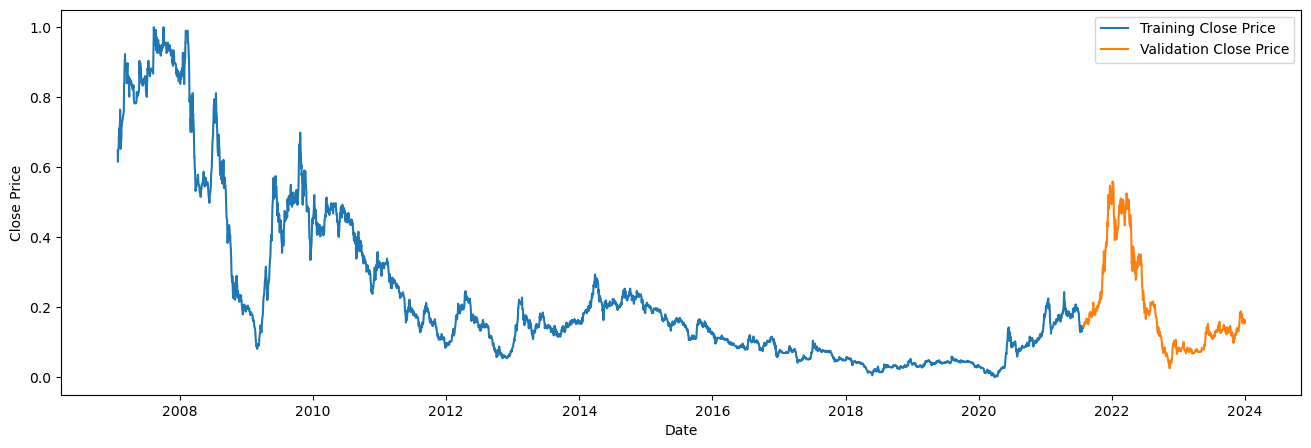

In [19]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(training_datasets.index, training_datasets["Close"], label="Training Close Price")
ax.plot(validation_datasets.index, validation_datasets["Close"], label="Validation Close Price")
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
plt.show()

## Datasets

In [20]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, datasets, time_steps, transform=None):
        X, y = [], []
        for i in range(len(datasets)-time_steps):
            X.append(datasets[i:i+time_steps])
            y.append(datasets[i+time_steps][3])
        self.X = X
        self.y = y
        self.n_samples = len(X)
        self.transform = transform

    def __getitem__(self, index):
        sample = self.X[index], self.y[index]
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return self.n_samples
        
class ToTensor:
    def __call__(self, sample):
        X, y = sample
        return torch.tensor(X), torch.tensor(y)

np_training = training_datasets.to_numpy(dtype='float32') # (3610, 5)
np_validation = validation_datasets.to_numpy(dtype='float32') # (610, 5)
# Datasets
train_dataset = Datasets(np_training, time_steps, transform=ToTensor()) # (3610, 5)
val_dataset = Datasets(np_validation, time_steps, transform=ToTensor()) # (610, 5)

## Dataloader

In [21]:
# Dataloader
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
print(len(train_dataloader.dataset), len(val_dataloader.dataset)) # 3600 600

3600 600


## LSTM Model

In [7]:
class LSTM(nn.Module):
    def __init__(self, batch_size, time_steps, hidden_size, input_size, num_layers, dropout=0.2):
        super().__init__()
        # (batch, seq, feature)
        self.batch_size = batch_size
        self.time_steps = time_steps
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, x):
        # Initial hidden state cell, memory state 
        # h_0: num_layers, batch_size, hidden_size
        h_0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size, dtype=torch.float).to(device)
        c_0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size, dtype=torch.float).to(device)
        out, _ = self.lstm(x, (h_0, c_0))
        # output: batch_size, time_steps, hidden_size
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

model = LSTM(batch_size, time_steps, hidden_size, input_size, num_layers)
model.to(device)

LSTM(
  (lstm): LSTM(5, 256, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

## Loss, Optimizer

In [8]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y) + 1e-6)
        return loss

loss_fn = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [9]:
def train_epoch(epoch, train_dataloader, model, loss_fn, optimizer, device):
    model.train()
    n_steps = len(train_dataloader)
    epoch_loss = 0
    n_samples = 0
    for i, (X_batch, y_batch) in enumerate(train_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        batch_size = X_batch.shape[0]
        # Forward
        outputs = model(X_batch)
        loss = loss_fn(outputs.squeeze(), y_batch)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Loss
        epoch_loss += loss.detach().item()*X_batch.size(0)
        n_samples += X_batch.size(0)
        
    return epoch_loss / n_samples

## Validation

In [10]:
def val_epoch(val_dataloader, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        n_steps = len(val_dataloader)
        y_preds = []
        y_labels = []
        val_loss = 0
        n_samples = 0
        for i, (X_val, y_val) in enumerate(val_dataloader):
            X_val, y_val = X_val.to(device), y_val.to(device)
            batch_size = X_val.shape[0]
            # Predict
            y_pred = model(X_val)
            y_pred = y_pred.reshape(y_val.shape[0])
            y_preds = np.append(y_preds, y_pred.detach().cpu().numpy())
            y_labels = np.append(y_labels, y_val.detach().cpu().numpy())
            # Loss
            loss = loss_fn(y_pred.squeeze(), y_val)
            val_loss += loss.detach().item()*X_val.size(0)
            n_samples += X_val.size(0)

        return val_loss / n_samples, y_preds, y_labels

## Looping Epoch

In [11]:
y_preds, y_labels = [], []
for epoch in range(num_epochs):
    train_loss = train_epoch(epoch, train_dataloader, model, loss_fn, optimizer, device)
    val_loss, y_preds, y_labels = val_epoch(val_dataloader, model, loss_fn, device)
    print(f"Epoch {epoch+1}/{num_epochs}, loss_training = {train_loss:.4f}, loss_validation = {val_loss:.4f}")
# Save model
torch.save(model.state_dict(), SAVE_MODEL_PATH)

Epoch 1/200, loss_training = 0.0935, loss_validation = 0.0268
Epoch 2/200, loss_training = 0.0243, loss_validation = 0.0188
Epoch 3/200, loss_training = 0.0239, loss_validation = 0.0201
Epoch 4/200, loss_training = 0.0216, loss_validation = 0.0163
Epoch 5/200, loss_training = 0.0215, loss_validation = 0.0156
Epoch 6/200, loss_training = 0.0214, loss_validation = 0.0158
Epoch 7/200, loss_training = 0.0199, loss_validation = 0.0168
Epoch 8/200, loss_training = 0.0191, loss_validation = 0.0174
Epoch 9/200, loss_training = 0.0188, loss_validation = 0.0149
Epoch 10/200, loss_training = 0.0181, loss_validation = 0.0144
Epoch 11/200, loss_training = 0.0193, loss_validation = 0.0180
Epoch 12/200, loss_training = 0.0185, loss_validation = 0.0143
Epoch 13/200, loss_training = 0.0173, loss_validation = 0.0142
Epoch 14/200, loss_training = 0.0182, loss_validation = 0.0175
Epoch 15/200, loss_training = 0.0193, loss_validation = 0.0137
Epoch 16/200, loss_training = 0.0170, loss_validation = 0.0148
E

## Plot Validation Datasets

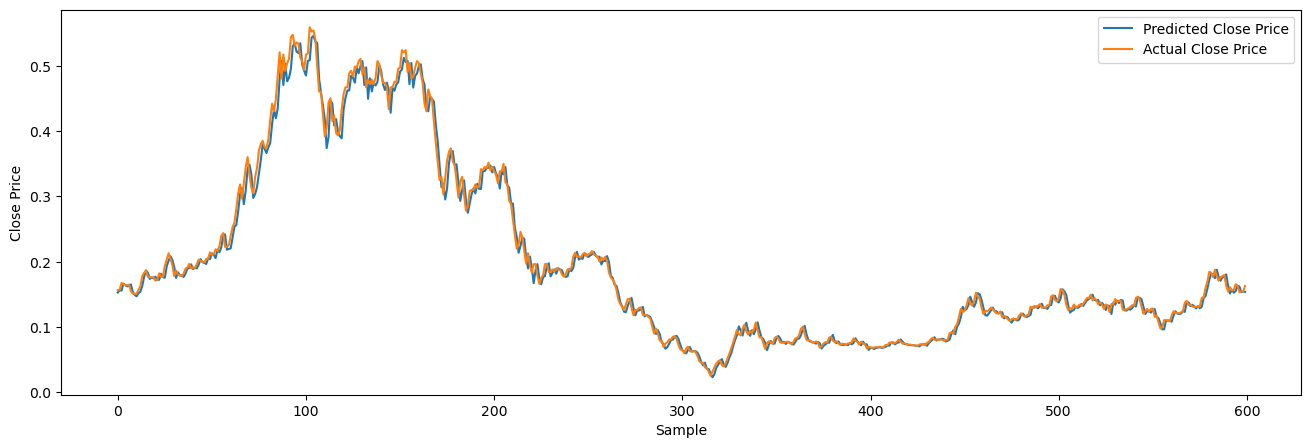

In [12]:
fig, ax = plt.subplots(figsize=(16, 5))
x_axis = np.arange(len(y_preds))
ax.plot(x_axis, y_preds, label="Predicted Close Price")
ax.plot(x_axis, y_labels, label="Actual Close Price")
ax.set_xlabel('Sample')
ax.set_ylabel('Close Price')
ax.legend()
plt.show()

## Plot for the latest of 60 days

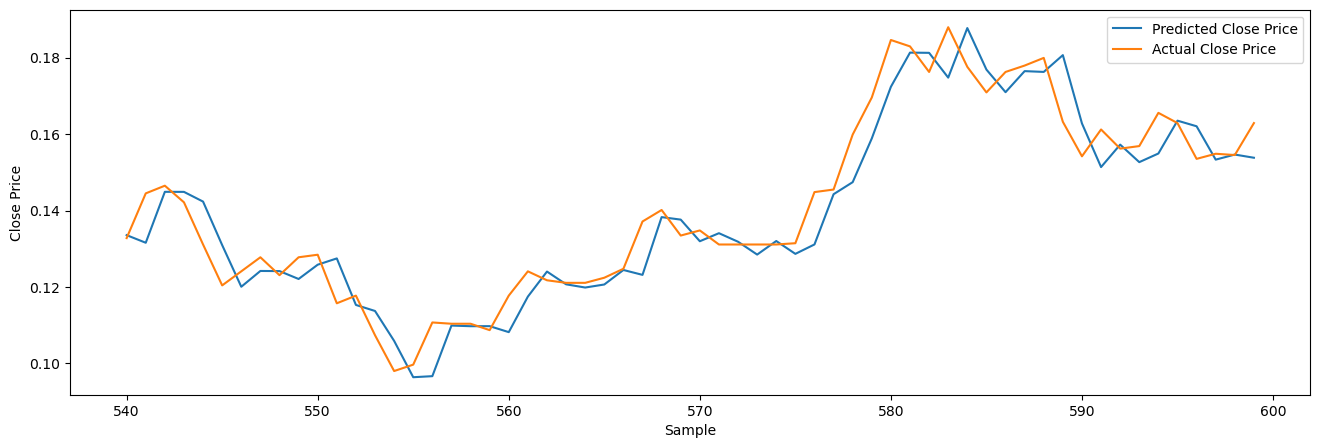

In [13]:
fig, ax = plt.subplots(figsize=(16, 5), dpi=100)
x_axis = np.arange(len(y_preds))
ax.plot(x_axis[-60:], y_preds[-60:], label="Predicted Close Price")
ax.plot(x_axis[-60:], y_labels[-60:], label="Actual Close Price")
ax.set_xlabel('Sample')
ax.set_ylabel('Close Price')
ax.legend()
plt.show()

## Predict for the next 04-01-2024

In [14]:
# Prepare for the last 30 days until 04-01-2024
last_30_days_upto_03_01_2024 = df[-30:]
np_last_30_days = last_30_days_upto_03_01_2024.to_numpy(dtype="float32")
X_np = torch.from_numpy(np_last_30_days)
X_dup = np.tile(X_np, (100, 1, 1))
X_tensor = torch.tensor(X_dup)
model.eval()
with torch.no_grad():
    X_input = X_tensor.to(device)
    predict = model(X_input)
    scaled_predict_scala = predict.detach().cpu().numpy()[0][0]
    print(scaled_predict_scala)
    inverse_prediction = SCALER["Close"].inverse_transform(scaled_predict_scala.reshape(-1, 1))
    print(inverse_prediction)

0.15957168
[[6.6011133]]
